In [87]:
import math

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

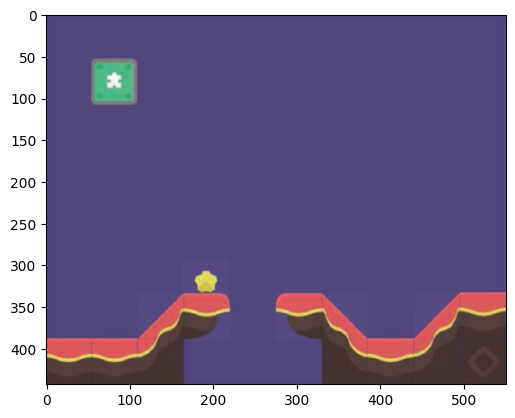

In [88]:
image = Image.open('input_platform_level.png')
plt.figure()
plt.imshow(image)
plt.show()

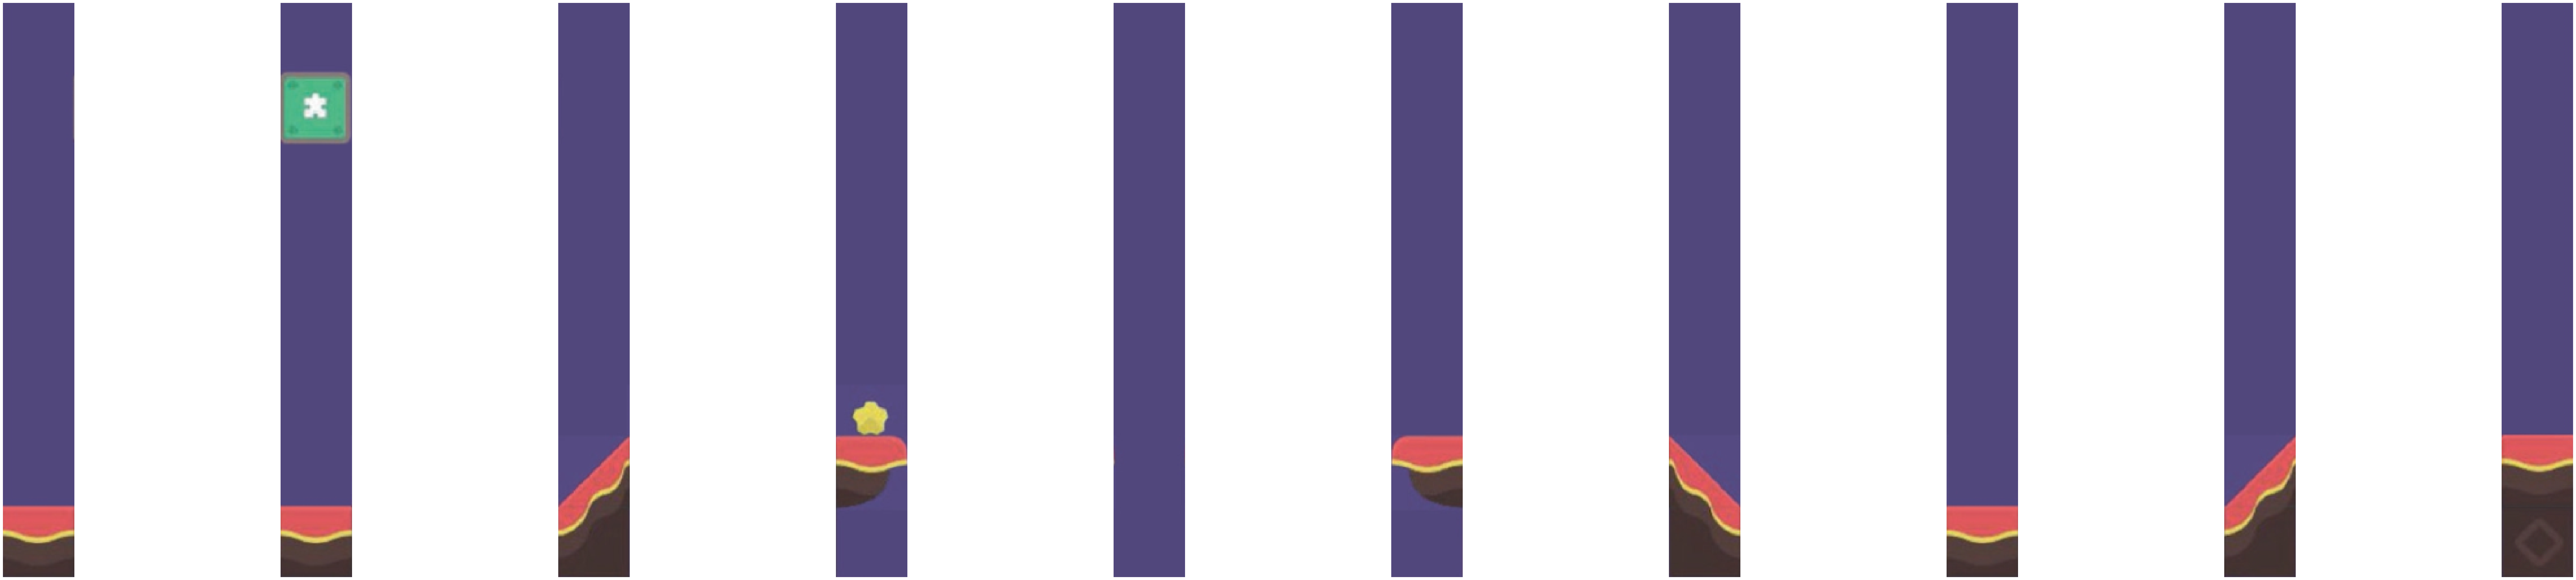

In [89]:
image_width, image_height = image.size

segment_width = image_width // 10
segmented_images = []

for i in range(10):
    left = i * segment_width
    upper = 0
    right = (i + 1) * segment_width
    lower = image_height
    segment = image.crop((left, upper, right, lower))
    segmented_images.append(segment)

fig, axes = plt.subplots(1, 10, figsize=(100, 20))

for i, ax in enumerate(axes):
    ax.imshow(segmented_images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [90]:
#Possible improvement is to programmatically check if the column is different enough to warrant a new label
col_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'A', 'C', 'H']
col_to_segment = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 9
}

forward_adjacency_rules = {
    'A': set(),
    'B': set(),
    'C': set(),
    'D': set(),
    'E': set(),
    'F': set(),
    'G': set(),
    'H': set(),
}

backwards_adjacency_rules = {
    'A': set(),
    'B': set(),
    'C': set(),
    'D': set(),
    'E': set(),
    'F': set(),
    'G': set(),
    'H': set(),
}
for i in range(len(col_labels)):
    forward_adjacency_rules[col_labels[i]].add(col_labels[(i+1) % len(col_labels)])

for i in range(len(col_labels)):
    backwards_adjacency_rules[col_labels[i]].add(col_labels[(i-1)])

print(f"Forward Adjacency Rules {forward_adjacency_rules}")
print(f"Backwards Adjacency Rules {backwards_adjacency_rules}")

Forward Adjacency Rules {'A': {'B', 'C'}, 'B': {'C'}, 'C': {'D', 'H'}, 'D': {'E'}, 'E': {'F'}, 'F': {'G'}, 'G': {'A'}, 'H': {'A'}}
Backwards Adjacency Rules {'A': {'G', 'H'}, 'B': {'A'}, 'C': {'A', 'B'}, 'D': {'C'}, 'E': {'D'}, 'F': {'E'}, 'G': {'F'}, 'H': {'C'}}


In [91]:
def get_most_constrained_index(level):
    option_lengths = [len(column) for column in new_level]
    min_index = -1
    min_num_options = math.inf
    for i in range(len(option_lengths)):
        if 1 < option_lengths[i] < min_num_options:
            min_index = i
            min_num_options = option_lengths[i]

    return min_index

def propagate(level, index, direction):
    column_options = level[index]
    if index > 0 and direction != 'forwards':
        enforced_constraint_options = set()
        for option in column_options:
            for back in backwards_adjacency_rules[option]:
                enforced_constraint_options.add(back)

        prev_col_options = set(level[index - 1])
        level[index - 1] = list(prev_col_options.intersection(enforced_constraint_options))
        if len(level[index - 1]) == 0:
            raise RuntimeError("No Valid Solutions")
        propagate(level, index - 1, 'backwards')
    elif index < len(level) - 1 and direction != 'backwards':
        enforced_constraint_options = set()
        for option in column_options:
            for forward in forward_adjacency_rules[option]:
                enforced_constraint_options.add(forward)

        next_col_options = set(level[index + 1])
        level[index + 1] = list(next_col_options.intersection(enforced_constraint_options))
        if len(level[index + 1]) == 0:
            raise RuntimeError("No Valid Solutions")
        propagate(level, index + 1, 'forwards')


def select_and_propagate(level, index):
    selected_option = np.random.choice(level[index])
    level[index] = [str(selected_option)]
    propagate(level, index, 'both')
    return level

In [100]:
columns_to_create = 15
new_level = []
max_tries = 10000

cur_try = 0
while True:
    try:
        new_level = [['A','B','C', 'D', 'E', 'F', 'G']] * columns_to_create
        while np.any([len(column) != 1 for column in new_level]):
            index_to_collapse = get_most_constrained_index(new_level)
            if index_to_collapse == -1:
                break
            new_level = select_and_propagate(new_level, index_to_collapse)
        break
    except:
        print("Retrying...")
        cur_try += 1
        if cur_try >= max_tries:
            break
        continue
    
print(f"Final level {new_level}")

Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Final level [['B'], ['C'], ['D'], ['E'], ['F'], ['G'], ['A'], ['C'], ['D'], ['E'], ['F'], ['G'], ['A'], ['B'], ['C']]


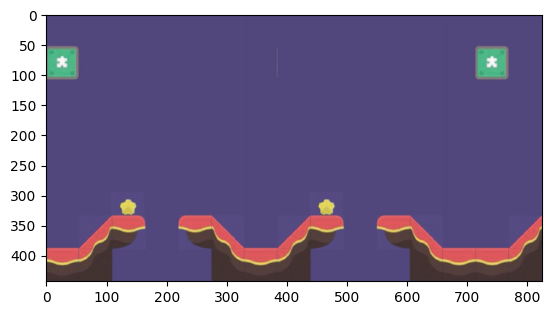

In [101]:
# Open all images
final_columns = []
for col in new_level:
    img_seg_index = col_to_segment[col[0]]
    final_columns.append(segmented_images[img_seg_index])

total_width = sum(img.width for img in final_columns)
max_height = max(img.height for img in final_columns)

concatenated_image = Image.new('RGB', (total_width, max_height))

# Paste each image into the new image, one after the other
x_offset = 0
for img in final_columns:
    concatenated_image.paste(img, (x_offset, 0))
    x_offset += img.width

plt.figure()
plt.imshow(concatenated_image)
plt.show()